## import & utils


In [1]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from tqdm.auto import trange
import jraph
import numpy as np

pl.style.use("dark_background")


def np2pil(a):
    a = np.asarray(a)
    if a.dtype.kind == "f":
        a = np.uint8(a.clip(0, 1) * 255)
    return PIL.Image.fromarray(a)


def imshow(a):
    display(np2pil(a))


def zoom(a, k=2):
    return np.repeat(np.repeat(a, k, 1), k, 0)


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), "constant")
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a

/home/marcello/miniconda3/envs/boolean_nca_cc_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax
import jax.numpy as jp
import optax
from flax import nnx

In [3]:
%load_ext autoreload
%autoreload 2

## Params

In [4]:
from boolean_nca_cc import generate_layer_sizes

In [5]:
input_n, output_n = 4, 4
arity = 2
layer_sizes = generate_layer_sizes(input_n, output_n, arity, layer_n=4)
loss_type = "l4"

In [6]:
layer_sizes

[(4, 1), (16, 2), (16, 2), (16, 2), (8, 1), (4, 1)]

## Training


### BackProp

In [7]:
from boolean_nca_cc.circuits.model import gen_circuit
from boolean_nca_cc.circuits.train import TrainState, train_step
from boolean_nca_cc.circuits.viz import evaluate_and_visualize
from boolean_nca_cc.circuits.tasks import get_task_data

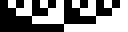

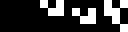

In [8]:
key = jax.random.PRNGKey(42)
wires, logitsbp = gen_circuit(key, layer_sizes, arity=arity)

opt = optax.adamw(1, 0.8, 0.8, weight_decay=1e-1)
state = TrainState(params=logitsbp, opt_state=opt.init(logitsbp))


case_n = 1 << input_n
x = jp.arange(case_n)
x, y0 = get_task_data(
    "binary_multiply", case_n, input_bits=input_n, output_bits=output_n
)

zoom_factor = 8
imshow(zoom(x.T, zoom_factor))
imshow(zoom(y0.T, zoom_factor))

In [9]:
loss_log_bp = []
aux_log_bp = []

In [10]:
pbar = trange(100)
for i in pbar:
    loss, aux, state = train_step(state, opt, wires, x, y0, loss_type, do_train=True)
    loss_log_bp.append(loss)
    aux_log_bp.append(aux)
    pbar.set_postfix_str(
        f"loss: {loss.item():.3E}, accuracy: {aux['accuracy'].item():.2%}"
        + (
            f" | hard_loss: {aux['hard_loss'].item():.3E}, hard_accuracy: {aux['hard_accuracy'].item():.2%}"
            if "hard_loss" in aux
            else ""
        )
    )

100%|██████████| 100/100 [00:05<00:00, 19.51it/s, loss: 1.155E-05, accuracy: 100.00% | hard_loss: 0.000E+00, hard_accuracy: 100.00%]


In [11]:
%timeit train_step(state, opt, wires, x, y0, loss_type, do_train=True)

6.3 ms ± 361 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


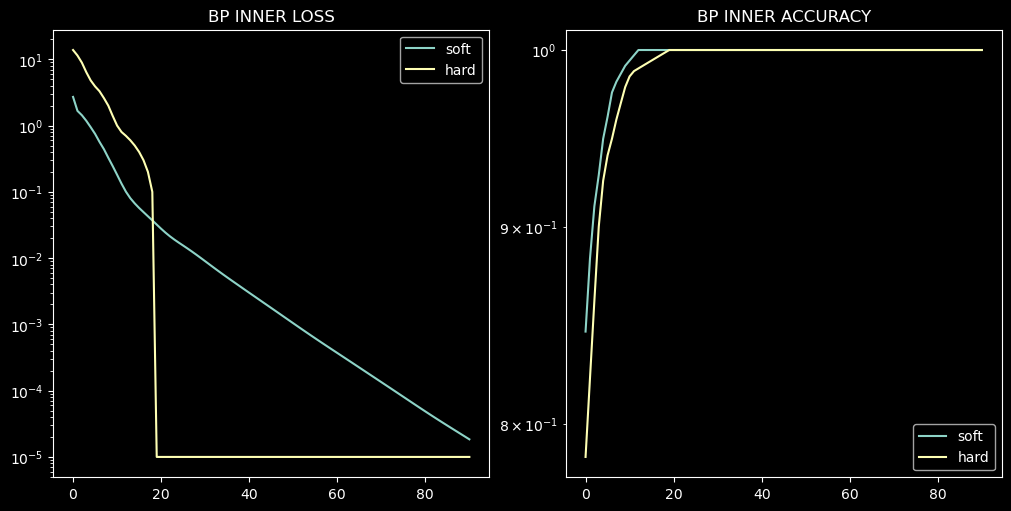

In [12]:
def plot_losses(
    loss_log, aux_log, figax=None, title=None, plot_accuracy=False, plot_hard=True
):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    v = len(loss_log) // 10

    if not plot_accuracy:
        smooth_losses = np.convolve(loss_log, np.ones(v) / v, mode="valid")
        hard_losses = [aux["hard_loss"] for aux in aux_log]
        smooth_hard_losses = np.convolve(hard_losses, np.ones(v) / v, mode="valid")
        ax.plot(smooth_losses, label="soft")
        if plot_hard:
            ax.plot(jp.maximum(smooth_hard_losses, 1e-5), label="hard")
    else:
        accs = [aux["accuracy"] for aux in aux_log]
        smooth_accs = np.convolve(accs, np.ones(v) / v, mode="valid")
        ax.plot(smooth_accs, label="soft")
        hard_accs = [aux["hard_accuracy"] for aux in aux_log]
        smooth_hard_accs = np.convolve(hard_accs, np.ones(v) / v, mode="valid")
        if plot_hard:
            ax.plot(smooth_hard_accs, label="hard")

    ax.legend()
    ax.set_yscale("log")

    if title is not None:
        ax.set_title(title)


fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(loss_log_bp, aux_log_bp, (fig, axs[0]), title="BP INNER LOSS")
plot_losses(
    loss_log_bp,
    aux_log_bp,
    (fig, axs[1]),
    plot_accuracy=True,
    title="BP INNER ACCURACY",
)

In [13]:
bp_results = {
    "losses": loss_log_bp,
    "aux_log": aux_log_bp,
}

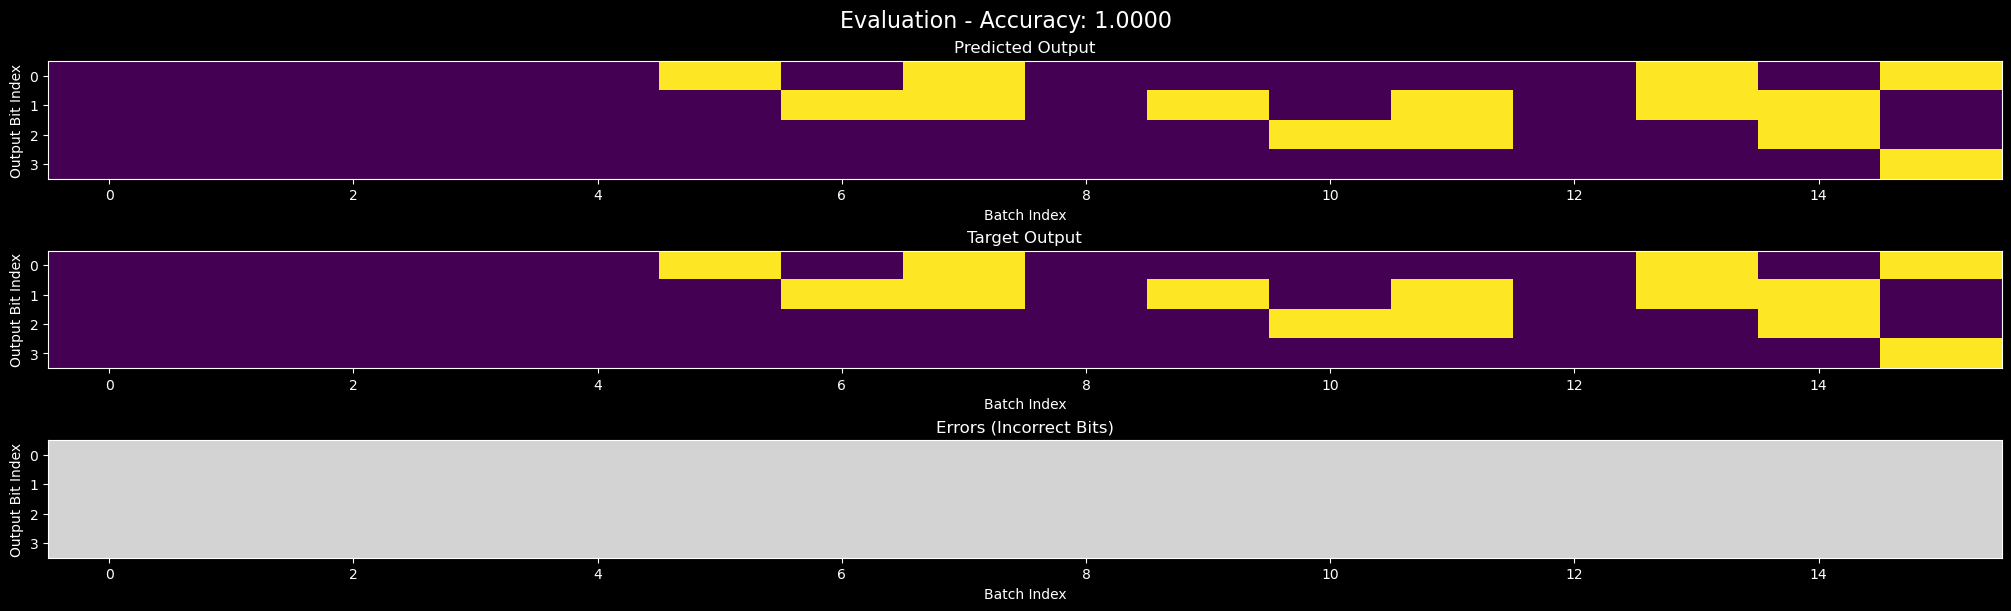

<Figure size 640x480 with 0 Axes>

In [14]:
metrics = evaluate_and_visualize(state.params, wires, x, y0, hard=True)

In [15]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

In [16]:
from boolean_nca_cc.utils import build_graph, extract_logits_from_graph
from boolean_nca_cc.circuits.train import loss_f_l4

### GNN

In [17]:
from boolean_nca_cc.models import CircuitGNN, run_gnn_scan
from boolean_nca_cc.training import train_model

In [18]:
hidden_dim = 128
hidden_features = 128
n_message_steps = 5
loss, aux = loss_f_l4(logitsbp, wires, x, y0)
graph = build_graph(
    logitsbp, wires, input_n, arity, hidden_dim=hidden_dim, loss_value=loss
)

gnn = CircuitGNN(
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    use_attention=False,
    arity=arity,
)

opt_fn = optax.adamw(1e-4, weight_decay=1e-5)
opt = nnx.Optimizer(gnn, opt_fn)

In [19]:
def loss_fn(gnn: CircuitGNN, graph: jraph.GraphsTuple, wires: jax.Array = wires):
    updated_graph = run_gnn_scan(gnn, graph, n_message_steps)
    updated_logits = extract_logits_from_graph(
        updated_graph, [l.shape for l in logitsbp]
    )
    loss, aux = loss_f_l4(updated_logits, wires, x, y0)
    return loss, updated_graph

In [20]:
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)
opt.update(grads)
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)
assert any(jax.tree.leaves(jax.tree.map(lambda x: x.any(), grads))), "No grads"

E0509 07:58:11.729727 2677319 buffer_comparator.cc:156] Difference at 16: 0, expected 38.0324
E0509 07:58:11.729764 2677319 buffer_comparator.cc:156] Difference at 17: 0, expected 36.884
E0509 07:58:11.729767 2677319 buffer_comparator.cc:156] Difference at 18: 0, expected 36.5775
E0509 07:58:11.729770 2677319 buffer_comparator.cc:156] Difference at 19: 0, expected 32.0467
E0509 07:58:11.729772 2677319 buffer_comparator.cc:156] Difference at 20: 0, expected 35.0431
E0509 07:58:11.729774 2677319 buffer_comparator.cc:156] Difference at 21: 0, expected 36.9005
E0509 07:58:11.729776 2677319 buffer_comparator.cc:156] Difference at 22: 0, expected 34.1246
E0509 07:58:11.729778 2677319 buffer_comparator.cc:156] Difference at 23: 0, expected 36.6262
E0509 07:58:11.729780 2677319 buffer_comparator.cc:156] Difference at 24: 0, expected 35.7572
E0509 07:58:11.729782 2677319 buffer_comparator.cc:156] Difference at 25: 0, expected 38.3505
2025-05-09 07:58:11.729791: E external/xla/xla/service/gpu/au

### Training

In [21]:
gnn_results = train_model(
    key=0,
    init_model=gnn,
    # CIRCUIT PARAMS
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    # TRAINING PARAMS
    epochs=2**15,
    n_message_steps=1,
    meta_batch_size=256,
    # WIRING MODE PARAMS
    wiring_mode="random",
    wiring_fixed_key=jax.random.PRNGKey(42),
    # LOSS PARAMS
    loss_type="l4",
    # OPTIMIZER PARAMS
    learning_rate=1e-3,
    weight_decay=1e-5,
    # LEARNING RATE SCHEDULER
    lr_scheduler="linear_warmup",
    # Model Params
    hidden_dim=hidden_dim,
    # POOL PARAMS : current mean avg of 100 steps before reset
    use_pool=True,
    pool_size=1024,
    reset_pool_fraction=0.075,
    reset_pool_interval=2**5,
    reset_strategy="combined",
)

Training GNN:   0%|          | 0/32768 [00:00<?, ?it/s]E0509 07:58:26.459687 2677319 buffer_comparator.cc:156] Difference at 16: 3.36312e-44, expected 8274.74
E0509 07:58:26.459729 2677319 buffer_comparator.cc:156] Difference at 17: 3.36312e-44, expected 8251.72
E0509 07:58:26.459733 2677319 buffer_comparator.cc:156] Difference at 18: 3.50325e-44, expected 8262.35
E0509 07:58:26.459735 2677319 buffer_comparator.cc:156] Difference at 19: 3.50325e-44, expected 8268.59
E0509 07:58:26.459737 2677319 buffer_comparator.cc:156] Difference at 20: 3.64338e-44, expected 8267.34
E0509 07:58:26.459740 2677319 buffer_comparator.cc:156] Difference at 21: 3.64338e-44, expected 8288.25
E0509 07:58:26.459745 2677319 buffer_comparator.cc:156] Difference at 22: 3.78351e-44, expected 8237.79
E0509 07:58:26.459747 2677319 buffer_comparator.cc:156] Difference at 23: 3.78351e-44, expected 8285.41
E0509 07:58:26.459749 2677319 buffer_comparator.cc:156] Difference at 24: 3.92364e-44, expected 8283.29
E0509 07:

In [22]:
try:
    gnn_results["model"] = nnx.state(gnn_results["model"])
    gnn_results["optimizer"] = nnx.state(gnn_results["optimizer"])
except ValueError:
    print("already converted")
    pass

already converted


In [23]:
# save gnn_results
import pickle

with open("gnn_results.pkl", "wb") as f:
    pickle.dump(gnn_results, f)

In [24]:
# recreate aux in old format
aux_log = [
    {
        "accuracy": accuracies,
        "hard_accuracy": hard_acc,
        "hard_loss": hard_loss,
    }
    for accuracies, hard_acc, hard_loss in zip(
        gnn_results["accuracies"],
        gnn_results["hard_accuracies"],
        gnn_results["hard_losses"],
    )
]

In [25]:
gnn_save = CircuitGNN(
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    use_attention=False,
    arity=arity,
)

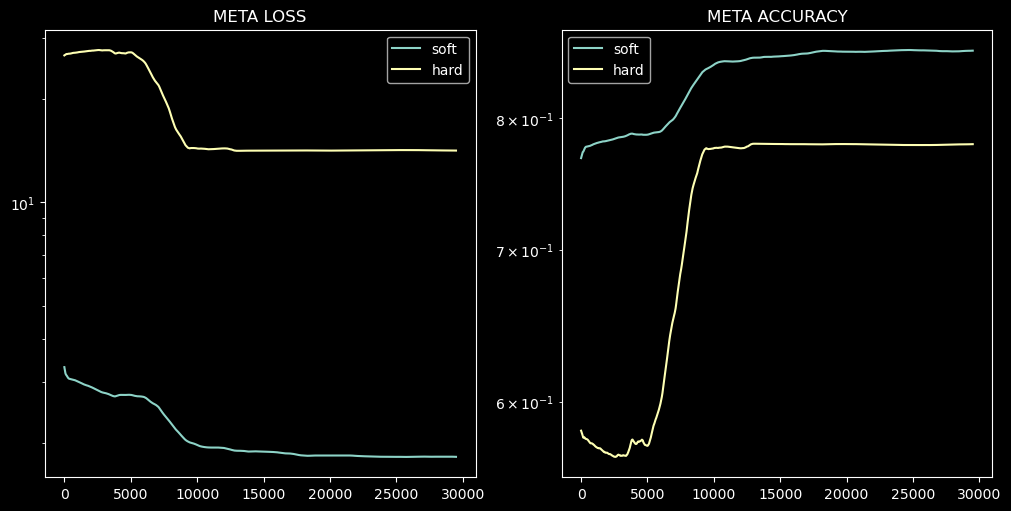

In [26]:
fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(
    gnn_results["losses"], aux_log, (fig, axs[0]), title="META LOSS", plot_hard=True
)
plot_losses(
    gnn_results["losses"],
    aux_log,
    (fig, axs[1]),
    plot_accuracy=True,
    title="META ACCURACY",
    plot_hard=True,
)

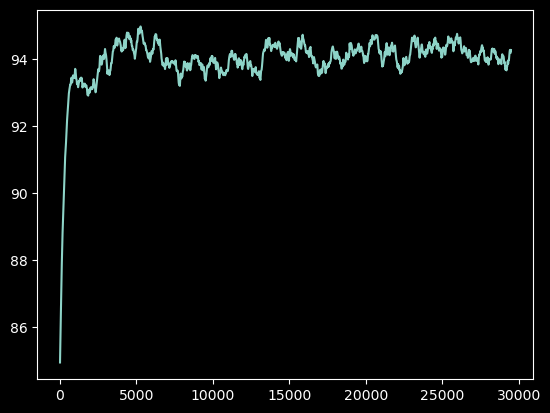

In [27]:
v = len(gnn_results["reset_steps"]) // 10
plt.plot(np.convolve(gnn_results["reset_steps"], np.ones(v) / v, mode="valid"))

In [28]:
# Get the inner loop losses
from boolean_nca_cc.training.evaluation import evaluate_model_stepwise

In [29]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
step_metrics = evaluate_model_stepwise(
    gnn,
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=100,
    arity=arity,
    hidden_dim=hidden_dim,
    loss_type="l4",
)

Evaluating GNN steps: 100%|██████████| 100/100 [00:06<00:00, 15.54it/s, Loss=1.9171, Accuracy=0.8594, Hard Acc=0.7656]


In [30]:
aux_log_stepwise = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics["soft_accuracy"],
        step_metrics["hard_accuracy"],
        step_metrics["hard_loss"],
    )
]

In [31]:
step_metrics.keys()

dict_keys(['step', 'soft_loss', 'hard_loss', 'soft_accuracy', 'hard_accuracy', 'logits_mean', 'acts'])

In [32]:
gnn_log_results = {
    "losses": step_metrics["soft_loss"],
    "aux_log": aux_log_stepwise,
}

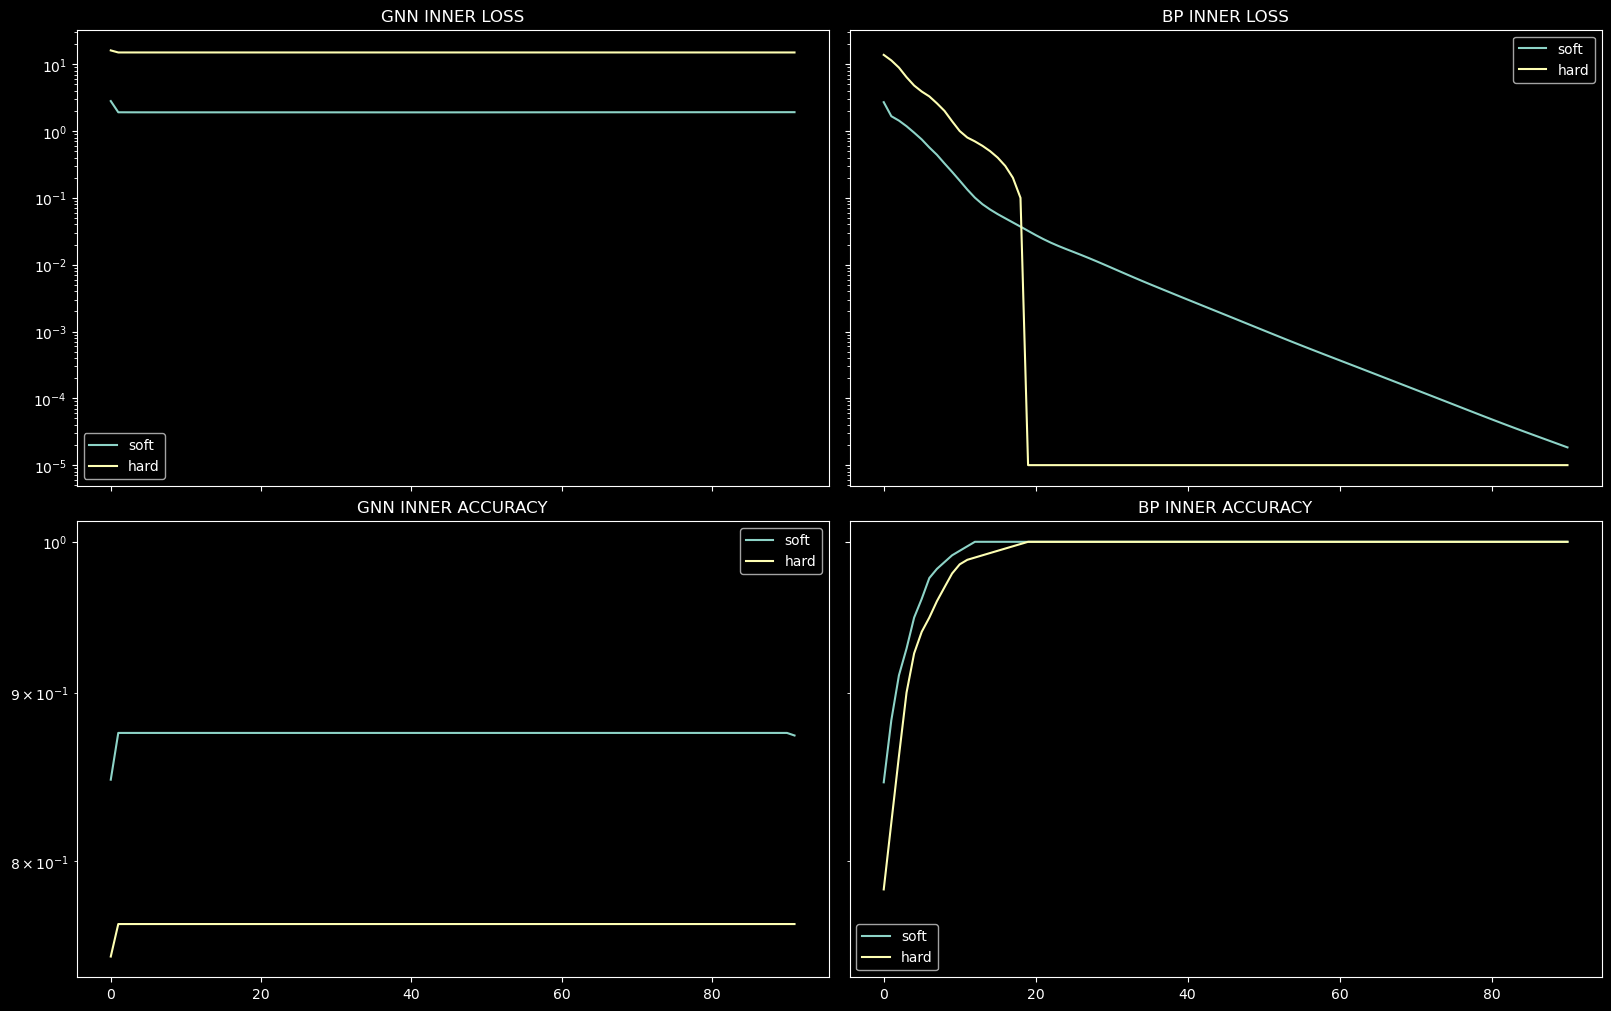

In [33]:
# Compare GNN and BP

fig, axs = plt.subplots(
    2, 2, figsize=(16, 10), sharey="row", sharex="col", constrained_layout=True
)

for method, axs_method, results in zip(
    ["GNN", "BP"], axs.T, [gnn_log_results, bp_results]
):
    for metric, ax in zip(["loss", "accuracy"], axs_method):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )

### Pool

In [34]:
from boolean_nca_cc.training.pool import GraphPool, initialize_graph_pool

In [35]:
init_pool = initialize_graph_pool(
    jax.random.PRNGKey(42),
    pool_size=1024,
    # circuit params
    layer_sizes=layer_sizes,
    arity=arity,
    input_n=input_n,
    # graph params
    hidden_dim=hidden_dim,
    loss_value=loss,
    wiring_mode="fixed",
)

In [36]:
init_pool.wires[0][3], init_pool.wires[0][2]

(Array([[3, 0, 2, 1, 3, 2, 2, 3],
        [3, 0, 1, 1, 2, 0, 1, 0]], dtype=int32),
 Array([[3, 0, 2, 1, 3, 2, 2, 3],
        [3, 0, 1, 1, 2, 0, 1, 0]], dtype=int32))

In [37]:
idxs, graphs, batch_of_wires, batch_of_logits = init_pool.sample(
    jax.random.PRNGKey(42), 16
)

In [38]:
graphs.nodes["logits"].sum(), idxs

(Array(0., dtype=float32),
 Array([ 196,   18,  183,  193,  653,  363,  385,  295,    6,  258,  552,
        1010,  409,  475,  972,  786], dtype=int32))

In [39]:
losses, updated_graphs = nnx.vmap(loss_fn, in_axes=(None, 0, 0))(
    gnn, graphs, batch_of_wires
)

E0509 08:11:48.218397 2677319 buffer_comparator.cc:156] Difference at 16: -3, expected 35.5982
E0509 08:11:48.218467 2677319 buffer_comparator.cc:156] Difference at 17: 3, expected 34.7902
E0509 08:11:48.218471 2677319 buffer_comparator.cc:156] Difference at 18: -3, expected 34.6141
E0509 08:11:48.218475 2677319 buffer_comparator.cc:156] Difference at 19: 3, expected 34.1968
E0509 08:11:48.218477 2677319 buffer_comparator.cc:156] Difference at 20: -3, expected 36.1687
E0509 08:11:48.218480 2677319 buffer_comparator.cc:156] Difference at 21: -3, expected 32.2931
E0509 08:11:48.218483 2677319 buffer_comparator.cc:156] Difference at 22: 3, expected 36.9597
E0509 08:11:48.218486 2677319 buffer_comparator.cc:156] Difference at 23: 3, expected 34.7143
E0509 08:11:48.218488 2677319 buffer_comparator.cc:156] Difference at 24: -3, expected 36.9162
E0509 08:11:48.218491 2677319 buffer_comparator.cc:156] Difference at 25: 3, expected 35.5236
2025-05-09 08:11:48.218499: E external/xla/xla/service/

In [40]:
updated_graphs.nodes["logits"].sum(), idxs

(Array(2277.1018, dtype=float32),
 Array([ 196,   18,  183,  193,  653,  363,  385,  295,    6,  258,  552,
        1010,  409,  475,  972,  786], dtype=int32))

In [41]:
updated_batch_of_logits = jax.vmap(extract_logits_from_graph, in_axes=(0, None))(
    updated_graphs, [l.shape[1:] for l in batch_of_logits]
)

In [42]:
new_pool = init_pool.update(idxs, updated_graphs)

In [43]:
new_idxs, new_graphs, new_batch_of_wires, new_batch_of_logits = new_pool.sample(
    jax.random.PRNGKey(42), 16
)

In [44]:
(
    new_graphs.nodes["logits"].sum(),
    sum(jax.tree.map(lambda x: x.sum(), new_batch_of_logits)),
)

# Update cprrect

(Array(2277.1018, dtype=float32), Array(3278.085, dtype=float32))

In [45]:
new_pool = initialize_graph_pool(
    jax.random.PRNGKey(42),
    pool_size=1024,
    # circuit params
    layer_sizes=layer_sizes,
    arity=arity,
    input_n=input_n,
    # graph params
    hidden_dim=hidden_dim,
    loss_value=loss,
)

In [46]:
init_pool.reset_fraction(
    jax.random.PRNGKey(43), 0.1, new_pool.graphs, new_pool.wires, new_pool.logits
)

(GraphPool(size=1024, graphs=GraphsTuple(nodes={'gate_id': Array([[ 0,  1,  2, ..., 61, 62, 63],
        [ 0,  1,  2, ..., 61, 62, 63],
        [ 0,  1,  2, ..., 61, 62, 63],
        ...,
        [ 0,  1,  2, ..., 61, 62, 63],
        [ 0,  1,  2, ..., 61, 62, 63],
        [ 0,  1,  2, ..., 61, 62, 63]], dtype=int32), 'group': Array([[0, 0, 0, ..., 1, 2, 3],
        [0, 0, 0, ..., 1, 2, 3],
        [0, 0, 0, ..., 1, 2, 3],
        ...,
        [0, 0, 0, ..., 1, 2, 3],
        [0, 0, 0, ..., 1, 2, 3],
        [0, 0, 0, ..., 1, 2, 3]], dtype=int32), 'hidden': Array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
      

In [47]:
first_graph = jax.tree.map(lambda x: x[0], new_graphs)
first_graph.nodes["logits"].shape

first_logits = extract_logits_from_graph(
    first_graph, [l.shape[1:] for l in batch_of_logits]
)
sum(jax.tree.map(lambda x: x.sum(), first_logits)), first_graph.nodes["logits"].sum()

(Array(204.88037, dtype=float32), Array(142.31897, dtype=float32))

## Attention

In [48]:
from boolean_nca_cc.models.self_attention import (
    CircuitSelfAttention,
)

In [49]:
attn = CircuitSelfAttention(
    hidden_dim=hidden_dim,
    num_heads=4,
    num_layers=3,
    arity=arity,
    dropout_rate=0.1,
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    n_node=int(graph.n_node[0]),
)

opt_fn = optax.adamw(1e-3, weight_decay=1e-5)
opt = nnx.Optimizer(attn, opt_fn)

In [50]:
updated_graph = attn(graph)

E0509 08:11:55.253395 2677319 buffer_comparator.cc:156] Difference at 16: 0, expected 18.1722
E0509 08:11:55.253456 2677319 buffer_comparator.cc:156] Difference at 17: 0, expected 16.9724
E0509 08:11:55.253460 2677319 buffer_comparator.cc:156] Difference at 18: 0, expected 18.2503
E0509 08:11:55.253464 2677319 buffer_comparator.cc:156] Difference at 19: 0, expected 18.9115
E0509 08:11:55.253467 2677319 buffer_comparator.cc:156] Difference at 20: 0, expected 16.1955
E0509 08:11:55.253470 2677319 buffer_comparator.cc:156] Difference at 21: 0, expected 16.7721
E0509 08:11:55.253472 2677319 buffer_comparator.cc:156] Difference at 22: 0, expected 16.9774
E0509 08:11:55.253475 2677319 buffer_comparator.cc:156] Difference at 23: 0, expected 17.777
E0509 08:11:55.253477 2677319 buffer_comparator.cc:156] Difference at 24: 0, expected 18.7491
E0509 08:11:55.253480 2677319 buffer_comparator.cc:156] Difference at 25: 0, expected 18.9045
2025-05-09 08:11:55.253489: E external/xla/xla/service/gpu/au

In [51]:
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(attn, graph)
opt.update(grads)
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(attn, graph)
assert any(jax.tree.leaves(jax.tree.map(lambda x: x.any(), grads))), "No grads"

E0509 08:11:57.650493 2677319 buffer_comparator.cc:156] Difference at 16: 4.08799, expected 2.93288
E0509 08:11:57.650538 2677319 buffer_comparator.cc:156] Difference at 17: 0.675313, expected 2.98448
E0509 08:11:57.650542 2677319 buffer_comparator.cc:156] Difference at 18: -4.79189, expected 2.98404
E0509 08:11:57.650545 2677319 buffer_comparator.cc:156] Difference at 19: 1.76625, expected 3.22641
E0509 08:11:57.650548 2677319 buffer_comparator.cc:156] Difference at 20: 0.423483, expected 3.124
E0509 08:11:57.650550 2677319 buffer_comparator.cc:156] Difference at 21: 2.42474, expected 2.8705
E0509 08:11:57.650553 2677319 buffer_comparator.cc:156] Difference at 23: 2.40376, expected 3.10934
E0509 08:11:57.650555 2677319 buffer_comparator.cc:156] Difference at 24: 1.11581, expected 2.91096
E0509 08:11:57.650558 2677319 buffer_comparator.cc:156] Difference at 25: -0.365021, expected 3.54427
E0509 08:11:57.650560 2677319 buffer_comparator.cc:156] Difference at 26: -0.126409, expected 3.16

In [ ]:
attn_results = train_model(
    key=0,
    init_model=attn,
    # CIRCUIT PARAMS
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    # TRAINING PARAMS
    epochs=2**17,
    n_message_steps=1,
    meta_batch_size=256,
    # WIRING MODE PARAMS
    wiring_mode="random",
    wiring_fixed_key=jax.random.PRNGKey(42),
    # LOSS PARAMS
    loss_type="l4",
    # OPTIMIZER PARAMS
    learning_rate=1e-3,
    weight_decay=1e-5,
    # LEARNING RATE SCHEDULER
    lr_scheduler="linear_warmup",
    # Model Params
    hidden_dim=hidden_dim,
    # POOL PARAMS : current mean avg of 100 steps before reset
    use_pool=True,
    pool_size=1024,
    reset_pool_fraction=0.075,
    reset_pool_interval=2**5,
    reset_strategy="combined",
)

Training GNN:   0%|          | 0/131072 [00:00<?, ?it/s]E0509 08:12:11.451865 2677319 buffer_comparator.cc:156] Difference at 16: 0.0695407, expected 129.745
E0509 08:12:11.451931 2677319 buffer_comparator.cc:156] Difference at 17: 0.0681998, expected 134.079
E0509 08:12:11.451934 2677319 buffer_comparator.cc:156] Difference at 18: 0.165605, expected 125.192
E0509 08:12:11.451937 2677319 buffer_comparator.cc:156] Difference at 19: 0.114402, expected 132.758
E0509 08:12:11.451939 2677319 buffer_comparator.cc:156] Difference at 20: 0.702286, expected 124.169
E0509 08:12:11.451942 2677319 buffer_comparator.cc:156] Difference at 21: 0.0987266, expected 136.343
E0509 08:12:11.451944 2677319 buffer_comparator.cc:156] Difference at 22: 0.472713, expected 135.54
E0509 08:12:11.451946 2677319 buffer_comparator.cc:156] Difference at 23: 0.215551, expected 124.893
E0509 08:12:11.451948 2677319 buffer_comparator.cc:156] Difference at 24: 0.844654, expected 131.846
E0509 08:12:11.451950 2677319 buf

In [81]:
# save gnn_results
import pickle

with open("attn_results.pkl", "wb") as f:
    pickle.dump(gnn_results, f)

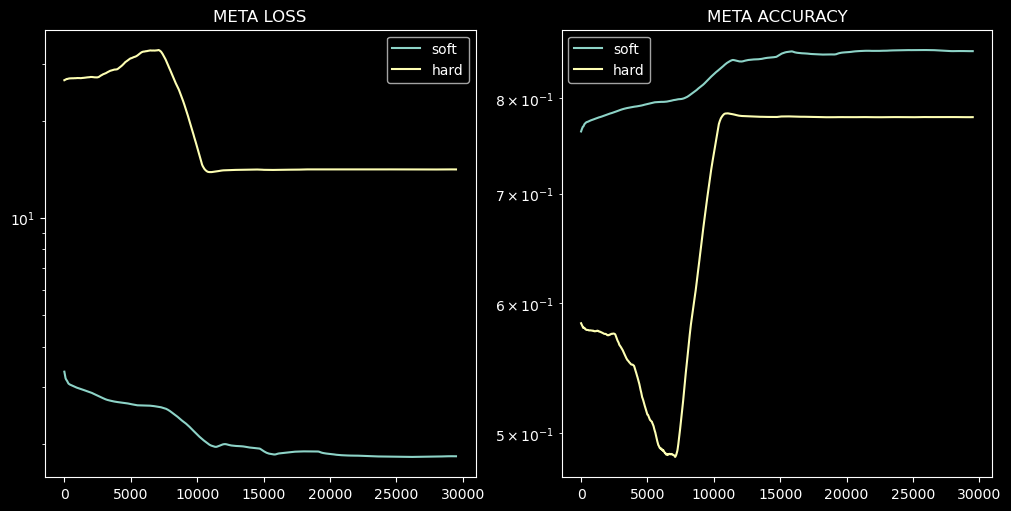

In [92]:
fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(
    gnn_results["losses"], aux_log, (fig, axs[0]), title="META LOSS", plot_hard=True
)
plot_losses(
    gnn_results["losses"],
    aux_log,
    (fig, axs[1]),
    plot_accuracy=True,
    title="META ACCURACY",
    plot_hard=True,
)

In [93]:
# Get the inner loop losses
from boolean_nca_cc.training.evaluation import evaluate_model_stepwise

In [94]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
step_metrics_attn = evaluate_model_stepwise(
    attn,
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=100,
    arity=arity,
    hidden_dim=hidden_dim,
    loss_type="l4",
)

Evaluating GNN steps:   0%|          | 0/100 [00:00<?, ?it/s]

In [95]:
aux_log_stepwise_attn = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics_attn["soft_accuracy"],
        step_metrics_attn["hard_accuracy"],
        step_metrics_attn["hard_loss"],
    )
]

In [96]:
step_metrics_attn.keys()

dict_keys(['step', 'soft_loss', 'hard_loss', 'soft_accuracy', 'hard_accuracy', 'logits_mean'])

In [97]:
attn_log_results = {
    "losses": step_metrics_attn["soft_loss"],
    "aux_log": aux_log_stepwise_attn,
}

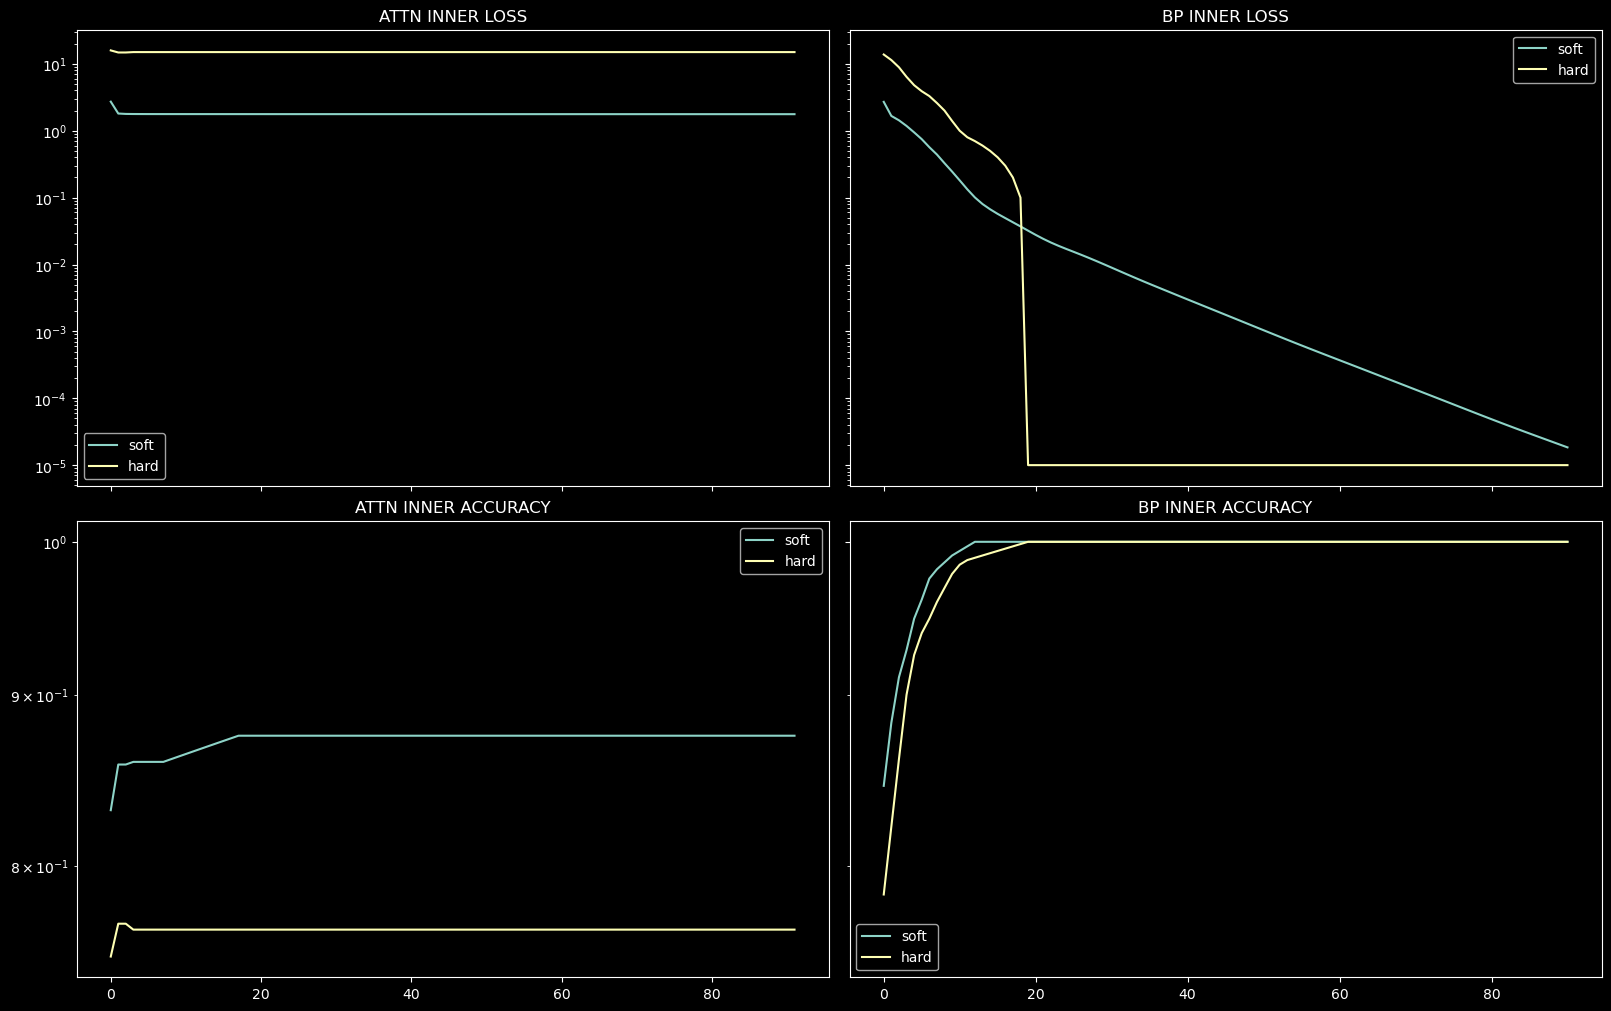

In [98]:
# Compare GNN and BP

fig, axs = plt.subplots(
    2, 2, figsize=(16, 10), sharey="row", sharex="col", constrained_layout=True
)

for method, axs_method, results in zip(
    ["ATTN", "BP"], axs.T, [attn_log_results, bp_results]
):
    for metric, ax in zip(["loss", "accuracy"], axs_method):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )